In [1]:
import pandas as pd
import numpy as np
import cPickle as pkl
import os.path as osp

TRY FINE GRAIN DETECTION OF TRUCKS PICK UPS CARS ETC?

In [2]:
# propogate error through return value
def make_int(lst):
    if type(lst) == list:
        for i in xrange(len(lst)):
            if type(lst[i]) == unicode:
                if lst[i] == u'': return None
                lst[i] = int(lst[i])
            elif type(lst[i]) == list:
                out = make_int(lst[i])
                if out is None:
                    return None
    return lst

def get_bbox(p):
    row_delim = ';'
    col_delim = ' '
    # remove array start-finish delims
    rows = p[1:-1].split(row_delim)
    str_poly = [row.split(col_delim) for row in rows]
    int_poly = make_int(str_poly)
    if int_poly is None:
        return None
    poly_points = np.array(int_poly)
    xmin, ymin = np.min(poly_points[:,0]) - 1, np.min(poly_points[:,1]) - 1
    xmax, ymax = np.max(poly_points[:,0]) - 1, np.max(poly_points[:,1]) - 1
    return [xmin, ymin, xmax, ymax]

In [128]:
for i in xrange(1,21):
    dsname = 'DataSet{}'.format(i)
    ds = pd.read_excel(dsname + '.xls')
    dsdic = {}
    for j in xrange(len(ds)):
        ser = ds.loc[j]
        if u'basedir' not in dsdic: dsdic[u'basedir'] = ser['Image Path'][3:]
        img_name = ser['Image Name'].replace('.tif', '.png')
        if img_name not in dsdic: dsdic[img_name] = []
        bbox = get_bbox(ser['Intersection Polygon'])
        if bbox is not None: dsdic[img_name].append(bbox)
    
    for k in dsdic.keys():
        if k == u'basedir': continue
        if len(dsdic[k]) == 0: 
            del dsdic[k]
            continue
#         dsdic[k] = np.vstack(dsdic[k])
    
    with open(dsname + '.pkl', 'wb') as f:
        pkl.dump(dsdic, f)

VISUALIZING BBOXES TO SEE THAT EVERYTHING'S OK

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

/media/data/lioruzan/OIRDS_v1_0/DataSet_2/87562818_4_6.png


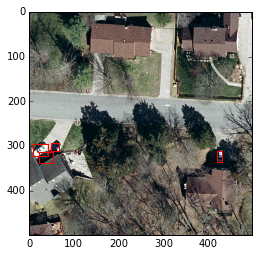

In [13]:
root = '/media/data/lioruzan/OIRDS_v1_0'
with open('DataSet2.pkl','rb') as f:
    ds = pkl.load(f)
pics = list(ds.keys())
pics.remove(u'basedir')
assert(type(pics)==list)

count=0
for pic in pics:
    count += 1
    if count != 13: continue
    pic_path = osp.join(root, ds['basedir'], pic)
    print(pic_path)
    im = plt.imread(pic_path)
    plt.imshow(im)
    currentAxis = plt.gca()
    # each row is a bbox
    for j in xrange(len(ds[pic])):
        det = ds[pic][j]
        coords = (det[0], det[1]), det[2]-det[0], det[3]-det[1]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=1))
    break


SPLIT DB TO (TRAIN+VAL) 85% TEST 15%

In [138]:
final_ds = {}
for i in xrange(1,21):
    dsname = 'DataSet{}.pkl'.format(i)
    with open(dsname, 'rb') as f:
        cur_ds = pkl.load(f)
    pics = list(cur_ds.keys())
    pics.remove(u'basedir')
    for pic in pics:
        new_pic = osp.join(cur_ds['basedir'], pic)
        final_ds[new_pic] = cur_ds[pic]
print(final_ds)

{u'DataSet_15/73840604_3073_1537_3329_1793.png': [[72, 205, 102, 217], [75, 227, 103, 241], [179, 206, 189, 230]], u'DataSet_7/46946744_257_3841_513_4097.png': [[16, 123, 48, 143], [42, 195, 63, 227]], u'DataSet_17/57196288_5633_1793_5889_2049.png': [[81, 182, 108, 207], [126, 137, 146, 169], [170, 166, 185, 197]], u'DataSet_9/27761951_5377_769_5633_1025.png': [[6, 85, 20, 117], [31, 92, 44, 122]], u'DataSet_13/83232319_257_2561_513_2817.png': [[157, 107, 171, 137]], u'DataSet_10/45922004_3073_2305_3329_2561.png': [[93, 109, 126, 124], [143, 142, 154, 173], [133, 106, 168, 120], [164, 126, 179, 161]], u'DataSet_7/46946744_2561_4865_2817_5121.png': [[139, 10, 164, 46], [210, 140, 242, 162], [226, 109, 248, 138]], u'DataSet_18/18464358_3073_2817_3329_3073.png': [[0, 92, 19, 123], [7, 68, 28, 101]], u'DataSet_19/51764373_1281_257_1537_513.png': [[65, 90, 87, 122], [78, 102, 106, 141]], u'DataSet_4/16546686_1537_8705_1793_8961.png': [[142, 117, 178, 142], [166, 86, 193, 124]], u'DataSet_1/

SPLIT DATA AND SAVE TO PICKLE FILES

In [139]:
with open('OIRDS_bbox.pkl', 'wb') as f:
    pkl.dump(final_ds,f)

In [141]:
import sklearn.cross_validation as cv

ss = cv.ShuffleSplit(908, n_iter=1, test_size=0.15)
for t1, t2 in ss:
    ss2 = cv.ShuffleSplit(len(t1), n_iter=1, test_size=0.15)
    for r1, r2 in ss2:
        train = t1[r1]
        val = t1[r2]
    test = t2

In [164]:
keys = final_ds.keys()
train_pics = []
for j in xrange(len(train)):
    train_pics.append(keys[train[j]])
val_pics = []
for j in xrange(len(val)):
    val_pics.append(keys[val[j]])
test_pics = []
for j in xrange(len(test)):
    test_pics.append(keys[test[j]])

train_ds = {}
val_ds = {}
test_ds = {}
for pic in train_pics:
    train_ds[pic] = final_ds[pic]
for pic in val_pics:
    val_ds[pic] = final_ds[pic]
for pic in test_pics:
    test_ds[pic] = final_ds[pic]

[u'DataSet_13/67862191_5889_1281_6145_1537.png', u'DataSet_16/30457478_5633_513_5889_769.png', u'DataSet_13/21774232_2305_1793_2561_2049.png', u'DataSet_15/58935671_2305_5121_2561_5377.png', u'DataSet_15/58935671_1_2817_257_3073.png', u'DataSet_1/68539289_2806_1021_3061_1276.png', u'DataSet_7/46946744_2817_8193_3073_8449.png', u'DataSet_19/61407638_2817_6401_3073_6657.png', u'DataSet_6/31741696_769_3329_1025_3585.png', u'DataSet_19/61407638_1025_257_1281_513.png', u'DataSet_1/22042086_2806_2806_3061_3061.png', u'DataSet_3/04822305_2817_6657_3073_6913.png', u'DataSet_11/72226507_1281_769_1537_1025.png', u'DataSet_17/31161652_4353_1281_4609_1537.png', u'DataSet_16/11946291_1_2049_257_2305.png', u'DataSet_3/04822305_1_2305_257_2561.png', u'DataSet_16/09542100_2049_1281_2305_1537.png', u'DataSet_20/17218079_2561_257_2817_513.png', u'DataSet_16/60162256_4609_1537_4865_1793.png', u'DataSet_14/27045076_1793_6657_2049_6913.png', u'DataSet_17/57196288_7425_2049_7681_2305.png', u'DataSet_3/04822

In [167]:
with open('OIRDS_train.pkl', 'wb') as f:
    pkl.dump(train_ds,f)
with open('OIRDS_val.pkl','wb') as f:
    pkl.dump(val_ds,f)
with open('OIRDS_test.pkl','wb') as f:
    pkl.dump(test_ds,f)